IDEAT: KMEANS VIX, Cap max weight for factor

<div style="font-size:14px;">
<strong>TO DO:</strong><br><br>
Tarkistaa ovatko regiimit oikein, exp. antaa ainoana kaikille neg sharpet<br>
Katsoa vielä financial turbulence koodi<br>
Data varmistukset (ei dataa tulevaisuudesta)<br><br>

<strong>Lisää features:</strong><br>
RSI<br>
Yield spread<br>
Muita??<br><br>

<strong>Muuta:</strong><br>
regiimi testaus drawdowneilla?<br><br>
regiimi specifi model ennustus?


<strong>Mallin kehitys:</strong><br>
1. Feature eliminointi<br>
2. Training interval<br>
3. Hyperparametrit
</div>



# GIT & imports

In [42]:
# # GitHub Repository Setup
#
# This cell navigates to `/content`, removes any previous clone of the repository,
# clones the latest version from GitHub, and lists the repository files.

# %%
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls


/content
Cloning into 'Gradu'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 219 (delta 40), reused 0 (delta 0), pack-reused 136 (from 1)
Receiving objects: 100% (219/219), 22.53 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/Gradu
 chatti_RF.ipynb	       Regiimi_prediction.ipynb  'RF REGIIMI HYVÄ TRAINING.ipynb'
'Financial turbulence.ipynb'   regime_pred.txt		 'RF_regime (3).ipynb'
 FT_source.xlsx		       RF_Gradu.ipynb		  THE_ONE.xlsx


In [43]:
skip_training = False
use_regime_split = True


In [44]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML


In [45]:
# Load and flatten the data
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
df = xls_file.parse("FF_test")
df.columns = df.columns.get_level_values(0)

print("Headers in the 'FF_test' sheet:")
print(df.columns)

# Features to used as predictive variables

#UNUSED: 'Financial Turbulance'
# 'H.Regimes' // TÄÄÄ RIKKI, EI OO NUMERO

FEATURES = ['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial condition', 'Drawdown', '10y-2y', 'Financial Turbulance']

# Model split by column
REGIMES_COLUMN = 'Regimes'

# Used factors
FACTORS = [
    'SMB',
    'HML',
    'RMW',
    'CMA'
]


BENCHMARK = [
    'USA Standard (Large+Mid Cap)'
]

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the 'FF_test' sheet:
Index(['Date', 'SMB', 'HML', 'RMW', 'CMA', 'VIXCLS', 'GDPC1', 'CPI', 'LEI',
       '10yr', 'Financial Turbulance', '10y-2y', 'Financial condition',
       'Drawdown', 'Regimes', 'Winning Factor',
       'USA Standard (Large+Mid Cap)'],
      dtype='object')


Description,Value
First observation date,1990-03-30 00:00:00
Last observation date,2024-10-31 00:00:00
Total number of observations,416


In [ ]:

# --- Define Helper Functions ---
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def compute_metrics(returns):
    """
    Compute key metrics for a returns series:
      - Annualized Return
      - Annualized Volatility (assuming monthly returns)
      - Total Cumulative Return
    """
    cumulative_returns = (1 + returns).cumprod()
    total_cum_return = cumulative_returns.iloc[-1] - 1
    ann_ret = annualized_return(returns)
    ann_vol = np.std(returns) * np.sqrt(12)
    return ann_ret, ann_vol, total_cum_return

# --- Compute Metrics for Benchmark and Each Factor ---
metrics = []

# Compute metrics for the benchmark.
benchmark_returns = df[BENCHMARK[0]]
bench_ann_ret, bench_ann_vol, bench_cum_return = compute_metrics(benchmark_returns)
metrics.append({
    "Strategy": "Benchmark",
    "Annualized Return": f"{bench_ann_ret*100:.2f}%",
    "Annualized Volatility": f"{bench_ann_vol*100:.2f}%",
    "Total Cumulative Return": f"{bench_cum_return*100:.2f}%"
})

# Compute metrics for each factor in FACTORS.
for factor in FACTORS:
    factor_returns = df[factor]
    factor_ann_ret, factor_ann_vol, factor_cum_return = compute_metrics(factor_returns)
    metrics.append({
        "Strategy": factor,
        "Annualized Return": f"{factor_ann_ret*100:.2f}%",
        "Annualized Volatility": f"{factor_ann_vol*100:.2f}%",
        "Total Cumulative Return": f"{factor_cum_return*100:.2f}%"
    })

# Create a DataFrame from the metrics.
metrics_df = pd.DataFrame(metrics)

# --- Display the Results as an HTML Table ---
display(HTML(metrics_df.to_html(index=False)))





Strategy,Annualized Return,Annualized Volatility,Total Cumulative Return
Benchmark,8.65%,14.89%,1673.42%
USA MOMENTUM Standard (Large+Mid Cap),12.00%,16.06%,4984.49%
USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap),7.75%,11.71%,1229.41%
USA RISK WEIGHTED Standard (Large+Mid Cap),8.41%,13.77%,1542.37%
USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),10.09%,14.84%,2699.29%
USA ENHANCED VALUE Standard (Large+Mid Cap),8.15%,16.42%,1412.00%


In [46]:
# # Prepare Data for Model Training – Data Cleaning & Verification

# we keep all rows and compute the winning factor as the factor (from FACTORS) with the highest value in each row.

# Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# Check missing values in feature columns (FEATURES) before dropping NAs.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in feature columns before dropping NA:")
print(missing_counts)

# Save the number of rows before dropping NA and then drop rows with missing values in FEATURES.
initial_rows_features = len(df)
X = df[FEATURES].dropna()
rows_after_drop = len(X)
dropped_rows = initial_rows_features - rows_after_drop

if dropped_rows > 0:
    print(f"\nDropped {dropped_rows} rows due to missing values in feature columns.")
else:
    print("\nNo missing values found in feature columns. Data is clean.")

# Compute the Winning Factor by taking the column (from FACTORS) that has the maximum value in each row.
# This assumes that the FACTORS columns exist in df and contain numeric values.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1)

# Define the target variable based on rows retained in X.
# The winning factor is encoded as a categorical variable.
y = df['Winning Factor'].astype('category').cat.codes.loc[X.index]
print("\nIndices aligned:", X.index.equals(y.index))

# Ensure the data is sorted by date.
df = df.sort_values('Date').reset_index(drop=True)

# Verify that all required columns exist.
# Here, we require the FEATURES columns, the 'USA Standard (Large+Mid Cap)' column,
# as well as all the FACTORS and the BENCHMARK columns.
required_columns = FEATURES + FACTORS + BENCHMARK
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
print("\nParameters and dataset verified.")

# Compute the counts for each winning factor.
winning_factor_counts = df['Winning Factor'].value_counts()

# Compute total count and append it as the last row.
total_counts = winning_factor_counts.sum()
winning_factor_counts = pd.concat([winning_factor_counts, pd.Series({'Total': total_counts})])

# Print the counts with "Total" as the last row.
print("\nWinning Factor counts:")
print(winning_factor_counts)


Total number of rows before cleaning: 416

Missing values in feature columns before dropping NA:
VIXCLS                  0
CPI                     0
LEI                     0
10yr                    0
Financial condition     0
Drawdown                0
10y-2y                  0
Financial Turbulance    0
dtype: int64

No missing values found in feature columns. Data is clean.

Indices aligned: True

Parameters and dataset verified.

Winning Factor counts:
RMW      131
SMB      129
HML       97
CMA       59
Total    416
dtype: int64


In [47]:
from IPython.display import display, HTML
start_row = 0     # Change this to your desired start row
end_row = 5    # Change this to your desired end row (or a large number to see all rows)

# Ensure that end_row does not exceed the total number of rows in the DataFrame.
if end_row > len(df):
    end_row = len(df)

# Print the preview.
print(f"\nPreview of the data from row {start_row} to row {end_row}:")
display(HTML(df.iloc[start_row:end_row].to_html(index=False)))



Preview of the data from row 0 to row 5:


Date,SMB,HML,RMW,CMA,VIXCLS,GDPC1,CPI,LEI,10yr,Financial Turbulance,10y-2y,Financial condition,Drawdown,Regimes,Winning Factor,USA Standard (Large+Mid Cap)
1990-03-30,0.0162,-0.0292,0.0204,-0.0102,21.40,0.003630,0.004687,63.5,8.59,9.383220,0.08,0.04713,0.000000,Normal,RMW,0.020702
1990-04-30,-0.0033,-0.0259,0.0178,-0.0098,18.10,0.003630,0.002333,63.6,8.79,4.756642,0.10,-0.13602,-0.023292,Normal,RMW,-0.023292
1990-05-31,-0.0235,-0.0383,0.0157,-0.0168,16.82,0.003630,0.001552,63.3,8.76,14.686352,0.19,-0.15632,0.000000,Normal,RMW,0.089444
1990-06-29,0.0135,-0.0193,-0.0103,-0.0039,18.39,0.000666,0.006197,63.3,8.48,8.020190,0.45,0.08472,-0.006432,Normal,SMB,-0.006432
1990-07-31,-0.0316,-0.0003,-0.0018,0.0321,28.18,0.000666,0.004619,63.3,8.47,25.637526,0.79,0.24339,-0.010680,Normal,CMA,-0.004276


In [48]:
# --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

# Dynamically extract the unique values in the REGIMES_COLUMN.
unique_regimes = df[REGIMES_COLUMN].unique()

# Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

# Create a dictionary mapping numeric codes to the regime names based on the unique values.
regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

# Now encode the Regimes column as numeric codes.
df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

# Create a mapping from numeric codes to original regime names.
regime_short_mapping = {code: name for code, name in regime_mapping.items()}

# Calculate the number of observations for each regime using value_counts (without reindexing).
obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

# Create a DataFrame preview of the regime mapping, including observation counts.
mapping_table_data = []
for code in regime_mapping.keys():
    mapping_table_data.append({
        "Numeric Code": code,
        "Original Name": regime_mapping.get(code, "N/A"),
        "Observations": obs_counts.get(code, 0)
    })

# Append a row with the total observations.
total_obs = obs_counts.sum()
mapping_table_data.append({
    "Numeric Code": "",
    "Original Name": "Total",
    "Observations": total_obs
})

# Create the DataFrame for regime mapping preview and print.
regime_mapping_df = pd.DataFrame(mapping_table_data)

from tabulate import tabulate
print("Preview of Dynamic Regime Mapping:")
print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


Preview of Dynamic Regime Mapping:
+----------------+-----------------+----------------+
| Numeric Code   | Original Name   |   Observations |
|----------------+-----------------+----------------|
| 0              | Drawdown        |             94 |
| 1              | Normal          |            322 |
|                | Total           |            416 |
+----------------+-----------------+----------------+


In [49]:
# # Encode Winning Factor & Build Mappings
#
# Pre-encode the 'Winning Factor' column and create dictionaries to map full factor names
# to shorter names and numeric IDs for later reference.
# A preview of the mapping is printed in a neat table format.

# %%
df['Winning Factor Encoded'] = df['Winning Factor'].astype('category').cat.codes
winning_factor_categories = df['Winning Factor'].astype('category').cat.categories
winning_factor_mapping = {i: cat for i, cat in enumerate(winning_factor_categories)}

# Define a mapping for shorter factor names similar to your previous approach.
factor_rename_mapping = {
    'USA MOMENTUM Standard (Large+Mid Cap)': 'Momentum',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)': 'MinVol',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)': 'RiskWeighted',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)': 'SectorNeutral',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)': 'EnhancedValue'
}

winning_factor_dict = {
    full_factor: {
        'full': full_factor,
        'short': factor_rename_mapping.get(full_factor, full_factor),
        'id': i
    }
    for i, full_factor in enumerate(winning_factor_categories)
}

# Create a small preview of the mapping as a DataFrame.
mapping_preview = pd.DataFrame([
    {"ID": d["id"], "Full Name": d["full"], "Short Name": d["short"]}
    for d in winning_factor_dict.values()
])

from tabulate import tabulate
print("Preview of Winning Factor Mapping:")
print(tabulate(mapping_preview, headers="keys", tablefmt="psql", showindex=False))


Preview of Winning Factor Mapping:
+------+-------------+--------------+
|   ID | Full Name   | Short Name   |
|------+-------------+--------------|
|    0 | CMA         | CMA          |
|    1 | HML         | HML          |
|    2 | RMW         | RMW          |
|    3 | SMB         | SMB          |
+------+-------------+--------------+


# Training

In [50]:
# # Define Rolling Window Parameters
#
# Set the training percentage, window size, and step size for the rolling window model training.

# %%
train_pct = 1.00  # Use 100% of data for rolling window training
train_end_idx = int(len(df) * train_pct)

window_size = 120   # Number of observations per training window
step_size = 1      # Step size for rolling window


### Hyperparameters Table

| Hyperparameter       | Purpose                                   | Common Choices                  |
|----------------------|-------------------------------------------|---------------------------------|
| `n_estimators`      | Number of trees                           | 100 (default), 200, 500         |
| `max_depth`         | Max tree depth                            | `None` (default), 10, 20        |
| `min_samples_split` | Min samples needed to split a node       | 2 (default), 10, 20             |
| `min_samples_leaf`  | Min samples in a leaf                    | 1 (default), 5, 10              |
| `max_features`      | Features per split                       | `'sqrt'` (default), `'log2'`, `None` |
| `bootstrap`         | Use bootstrap sampling                    | `True` (default), `False`       |
| `random_state`      | Set a random seed                         | `None`, 42, 0                   |
| `criterion`         | Splitting method                          | `'gini'` (default), `'entropy'` |
| `oob_score`        | Out-of-bag validation                     | `False` (default), `True`       |
| `n_jobs`           | Parallel training                         | `None`, `-1` (all CPUs)         |


In [91]:
# --- Code cell 11 ---
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Parameters:
overall_window_size = 60  # Overall training window size (from the full sorted data)
min_data_threshold = 3  # Minimum number of observations required

# Create an empty list to accumulate the results.
results = []

# Ensure the overall dataset is sorted by Date.
df_sorted = df.sort_values('Date').reset_index(drop=True)

# Loop over test rows starting at overall_window_size.
for i in range(overall_window_size, len(df_sorted)):
    # Get the test row (a single-row DataFrame)
    test_row = df_sorted.iloc[i]
    Predicted_month = test_row['Date']

    # If using regimes, extract the test regime
    if use_regime_split:
        test_regime = test_row[REGIMES_COLUMN]
    else:
        test_regime = None  # Not used if we're not splitting by regime

    # Define the overall rolling window as the N rows immediately preceding the test row.
    overall_train_window = df_sorted.iloc[i - overall_window_size : i]

    # Optionally filter the training window by the test regime
    if use_regime_split:
        regime_train_window = overall_train_window[ overall_train_window[REGIMES_COLUMN] == test_regime ]
    else:
        # If not splitting by regime, just use the entire rolling window
        regime_train_window = overall_train_window

    # If the filtered training window is too small, skip
    if len(regime_train_window) < min_data_threshold:
        print(f"Test row date {Predicted_month.date()}: only {len(regime_train_window)} obs (<{min_data_threshold}), skipping.\n")
        continue

    # Ensure that the last training observation is from a strictly earlier month (avoid same-month overlap).
    last_train_date = regime_train_window['Date'].iloc[-1]
    if last_train_date.year == Predicted_month.year and last_train_date.month >= Predicted_month.month:
        print(f"Test row {Predicted_month.date()}: last training date {last_train_date.date()} is in the same month, skipping.\n")
        continue

    # For logging, define the training window start and end dates.
    train_start_date = regime_train_window['Date'].iloc[0]
    train_end_date = last_train_date
    n_train = len(regime_train_window)
    print(f"Test row date: {Predicted_month.date()}")
    if use_regime_split:
        print(f"  Regime: {test_regime}, Training window: {train_start_date.date()} to {train_end_date.date()}, {n_train} obs")
    else:
        print(f"  No regime split. Training window: {train_start_date.date()} to {train_end_date.date()}, {n_train} obs")

    # Prepare training features and target
    X_train = regime_train_window[FEATURES].dropna()
    y_train = regime_train_window['Winning Factor'].loc[X_train.index]

    if len(X_train) < min_data_threshold:
        print("   -> After dropping NAs, not enough training data, skipping iteration.\n")
        continue

    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Prepare test features
    X_test = test_row[FEATURES].to_frame().T.dropna()
    if X_test.empty:
        print("   -> Test features are empty, skipping iteration.\n")
        continue

    # Predict probabilities and winner
    predicted_probabilities = rf_model.predict_proba(X_test)[0]
    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

    # Allocate return by weighting each factor's return by its predicted probability
    full_probs = np.zeros(len(FACTORS))
    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
        try:
            idx = FACTORS.index(cls)
            full_probs[idx] = prob
        except ValueError:
            print(f"Warning: Class '{cls}' not found in FACTORS.")

    allocated_return = (full_probs * test_row[FACTORS].values).sum()

    # Store results
    result = {
        'Regime': test_regime if use_regime_split else 'NoRegime',
        'Predicted_month': Predicted_month,
        'Train_Start_Date': train_start_date,
        'Train_End_Date': train_end_date,
        'Train_Count': len(X_train),
        'Feature_Importances': rf_model.feature_importances_,
        'Predicted_Probabilities': full_probs,
        'Predicted_Winner': predicted_winner,
        'Allocated_Return': allocated_return,
        'Actual_Winner': test_row['Winning Factor']
    }
    results.append(result)

    print("   -> Model trained and prediction made.\n")

# Convert the results list into a DataFrame.
results_df = pd.DataFrame(results)

print("Headers in results_df:")
print(results_df.columns.tolist())

# Display first few predictions
num_rows_to_show = 5
html_table = results_df.head(num_rows_to_show).to_html(index=False)
from IPython.display import display, HTML
display(HTML(html_table))

# Keep track that expansions haven't run yet
feature_importances_expanded = False
probabilities_expanded = False
regimes_converted = False
predicted_winner_converted = False

Test row date: 1995-03-31
  Regime: 1, Training window: 1990-03-30 to 1995-02-28, 52 obs
   -> Model trained and prediction made.

Test row date: 1995-04-28
  Regime: 1, Training window: 1990-04-30 to 1995-03-31, 52 obs
   -> Model trained and prediction made.

Test row date: 1995-05-31
  Regime: 1, Training window: 1990-05-31 to 1995-04-28, 52 obs
   -> Model trained and prediction made.

Test row date: 1995-06-30
  Regime: 1, Training window: 1990-06-29 to 1995-05-31, 52 obs
   -> Model trained and prediction made.

Test row date: 1995-07-31
  Regime: 1, Training window: 1990-07-31 to 1995-06-30, 52 obs
   -> Model trained and prediction made.

Test row date: 1995-08-31
  Regime: 1, Training window: 1990-11-30 to 1995-07-31, 52 obs
   -> Model trained and prediction made.

Test row date: 1995-09-29
  Regime: 1, Training window: 1990-11-30 to 1995-08-31, 53 obs
   -> Model trained and prediction made.

Test row date: 1995-10-31
  Regime: 1, Training window: 1990-11-30 to 1995-09-29, 5

Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Actual_Winner
1,1995-03-31,1990-03-30,1995-02-28,52,"[0.15981369645939364, 0.12436758061923721, 0.13098923310145294, 0.1231523737531808, 0.1748725269958217, 0.05779018448944496, 0.126162546228618, 0.10285185835285086]","[0.06, 0.71, 0.02, 0.21]",HML,-0.015143,CMA
1,1995-04-28,1990-04-30,1995-03-31,52,"[0.1613513536818529, 0.142505938454965, 0.14648442805585773, 0.12851402580911547, 0.15264387414031064, 0.04689470274518977, 0.12488097847004116, 0.09672469864266729]","[0.39, 0.43, 0.04, 0.14]",HML,0.007919,HML
1,1995-05-31,1990-05-31,1995-04-28,52,"[0.16302963964876366, 0.1501570093924528, 0.1556635296685386, 0.11092473792913583, 0.14530204368727542, 0.04617095050489461, 0.12713683267299952, 0.10161525649593948]","[0.14, 0.41, 0.03, 0.42]",CMA,0.006608,HML
1,1995-06-30,1990-06-29,1995-05-31,52,"[0.1645687272556669, 0.13951795239759998, 0.15061982990784412, 0.11598793488159163, 0.14741436466507513, 0.06676214079249199, 0.11160740798137002, 0.10352164211836015]","[0.08, 0.52, 0.04, 0.36]",HML,-0.019676,SMB
1,1995-07-31,1990-07-31,1995-06-30,52,"[0.1776728586654254, 0.1317023493558626, 0.14800591095523188, 0.1189078448132154, 0.14146604630226897, 0.05363748308732748, 0.1252262455082813, 0.10338126131238706]","[0.24, 0.47, 0.02, 0.27]",HML,-0.006993,SMB


In [92]:
# Optional: Expand the feature importances array into separate columns (only if not done already).
if not feature_importances_expanded:
    print("Expanding feature importances into separate columns...")
    for idx, feature in enumerate(FEATURES):
        results_df[f'FI_{feature}'] = results_df['Feature_Importances'].apply(lambda x: x[idx] if isinstance(x, np.ndarray) else np.nan)
        print(f"  Added column for feature importance: FI_{feature}")
    feature_importances_expanded = True  # Set the flag to True

# Optional: Expand predicted probabilities into separate columns (only if not done already).
if not results_df.empty and isinstance(results_df['Predicted_Probabilities'].iloc[0], np.ndarray) and not probabilities_expanded:
    num_probs = results_df['Predicted_Probabilities'].iloc[0].shape[0]
    print(f"Expanding predicted probabilities into {num_probs} separate columns...")

    for j in range(num_probs):
        # Assign the probability value to the new column 'Prob_{j}'
        results_df[f'Prob_{j}'] = results_df['Predicted_Probabilities'].apply(lambda x: x[j] if isinstance(x, np.ndarray) else np.nan)
        print(f"  Added column for predicted probability: Prob_{j}")

        # Rename the probability columns using the short factor names with '_prob' suffix
        factor_shortname_prob = factor_rename_mapping.get(FACTORS[j], FACTORS[j])  # Get short name
        results_df = results_df.rename(columns={f'Prob_{j}': f'{factor_shortname_prob}_prob'})  # Add '_prob' suffix
        print(f"  Renamed column 'Prob_{j}' to '{factor_shortname_prob}_prob'")
    probabilities_expanded = True  # Set the flag to True

# At the end of the loop, convert numeric regime codes back to their string names (only if not done already).
if not regimes_converted:
    print("Converting numeric regime codes back to their string names...")
    results_df['Regime'] = results_df['Regime'].apply(lambda x: regime_short_mapping.get(x, str(x)))
    print("  Regimes converted.")
    regimes_converted = True  # Set the flag to True

# Optional: You can also map the 'Predicted_Winner' back to its string name if it's encoded numerically (only if not done already).
if not predicted_winner_converted:
    print("Converting 'Predicted_Winner' from numeric codes to string names...")
    results_df['Predicted_Winner'] = results_df['Predicted_Winner'].apply(lambda x: regime_short_mapping.get(x, str(x)))
    print("  'Predicted_Winner' converted.")
    predicted_winner_converted = True  # Set the flag to True

# Display the first row as an HTML table
html_table = results_df.iloc[0:1].to_html(index=False)  # Select the first row
display(HTML(html_table))


Expanding feature importances into separate columns...
  Added column for feature importance: FI_VIXCLS
  Added column for feature importance: FI_CPI
  Added column for feature importance: FI_LEI
  Added column for feature importance: FI_10yr
  Added column for feature importance: FI_Financial condition
  Added column for feature importance: FI_Drawdown
  Added column for feature importance: FI_10y-2y
  Added column for feature importance: FI_Financial Turbulance
Expanding predicted probabilities into 4 separate columns...
  Added column for predicted probability: Prob_0
  Renamed column 'Prob_0' to 'SMB_prob'
  Added column for predicted probability: Prob_1
  Renamed column 'Prob_1' to 'HML_prob'
  Added column for predicted probability: Prob_2
  Renamed column 'Prob_2' to 'RMW_prob'
  Added column for predicted probability: Prob_3
  Renamed column 'Prob_3' to 'CMA_prob'
Converting numeric regime codes back to their string names...
  Regimes converted.
Converting 'Predicted_Winner' fr

Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Actual_Winner,FI_VIXCLS,FI_CPI,FI_LEI,FI_10yr,FI_Financial condition,FI_Drawdown,FI_10y-2y,FI_Financial Turbulance,SMB_prob,HML_prob,RMW_prob,CMA_prob
Normal,1995-03-31,1990-03-30,1995-02-28,52,"[0.15981369645939364, 0.12436758061923721, 0.13098923310145294, 0.1231523737531808, 0.1748725269958217, 0.05779018448944496, 0.126162546228618, 0.10285185835285086]","[0.06, 0.71, 0.02, 0.21]",HML,-0.015143,CMA,0.159814,0.124368,0.130989,0.123152,0.174873,0.05779,0.126163,0.102852,0.06,0.71,0.02,0.21


In [93]:

# Calculate the ending row. If it exceeds the number of rows in results_df, it will be set to the maximum.
end_row = start_row + num_rows_to_show
if end_row > len(results_df):
    end_row = len(results_df)

# Parameters
start_row = 0         # Change this to your desired starting row index.
num_rows_to_show = 50  # Change this to the number of rows you want to display.

# Calculate the ending row. If it exceeds the number of rows in results_df, it will be set to the maximum.
end_row = start_row + num_rows_to_show
if end_row > len(results_df):
    end_row = len(results_df)

# Create the 'Correct' column by comparing Predicted_Winner with Actual_Winner
results_df['Correct'] = results_df['Predicted_Winner'] == results_df['Actual_Winner']

# Identify the probability columns (e.g., Momentum_prob, MinVol_prob, etc.)
prob_cols = [col for col in results_df.columns if col.endswith('_prob')]

# Calculate 'Max_Probability' by taking the max of the probability columns
results_df['Max_Probability'] = results_df[prob_cols].max(axis=1)

# Select the required columns to display in the table
columns_to_display = [
    'Predicted_month', 'Regime', 'Correct', 'Predicted_Winner', 'Actual_Winner',
    'Allocated_Return', 'Max_Probability'
]

# Add the probability columns to the display list (to show them at the right side)
columns_to_display += prob_cols

# Filter the DataFrame to only include the required columns
table_data = results_df[columns_to_display].iloc[start_row:end_row]

# Convert 'Correct' column to boolean (True/False)
table_data['Correct'] = table_data['Correct'].apply(lambda x: 'True' if x else 'False')

# Generate a pretty HTML table using pandas' built-in functionality
html_table = table_data.to_html(index=False, escape=False)

# Display the HTML table
from IPython.display import HTML, display
display(HTML(html_table))






Predicted_month,Regime,Correct,Predicted_Winner,Actual_Winner,Allocated_Return,Max_Probability,SMB_prob,HML_prob,RMW_prob,CMA_prob
1995-03-31,Normal,False,HML,CMA,-0.015143,0.71,0.06,0.71,0.02,0.21
1995-04-28,Normal,True,HML,HML,0.007919,0.43,0.39,0.43,0.04,0.14
1995-05-31,Normal,False,CMA,HML,0.006608,0.42,0.14,0.41,0.03,0.42
1995-06-30,Normal,False,HML,SMB,-0.019676,0.52,0.08,0.52,0.04,0.36
1995-07-31,Normal,False,HML,SMB,-0.006993,0.47,0.24,0.47,0.02,0.27
1995-08-31,Normal,True,HML,HML,0.021569,0.52,0.33,0.52,0.04,0.11
1995-09-29,Normal,False,SMB,RMW,-0.008708,0.49,0.49,0.40,0.04,0.07
1995-10-31,Normal,False,HML,RMW,-0.009603,0.50,0.27,0.50,0.20,0.03
1995-11-30,Normal,False,HML,CMA,-0.000753,0.43,0.14,0.43,0.36,0.07
1995-12-29,Normal,True,CMA,CMA,0.009155,0.35,0.17,0.23,0.25,0.35


In [94]:
from sklearn.metrics import accuracy_score
from IPython.display import display, HTML
import numpy as np

# Calculate total test months considered.
# The loop started at overall_window_size and went to the end of df_sorted.
total_test_months = len(df_sorted) - overall_window_size
predicted_months = len(results_df)
skipped_months = total_test_months - predicted_months

# Check if the 'Actual_Winner' column exists.
if 'Actual_Winner' not in results_df.columns:
    print("Error: 'Actual_Winner' column not found in results_df. Please ensure that the true winning factor is saved as 'Actual_Winner'.")
else:
    # Compute the combined (weighted) accuracy over all predictions.
    combined_accuracy = accuracy_score(results_df['Actual_Winner'], results_df['Predicted_Winner'])
    total_predictions = len(results_df)
    correct_predictions = sum(results_df['Actual_Winner'] == results_df['Predicted_Winner'])

    # Assuming there are 'n' classes, random accuracy = 1/n.
    n_classes = len(winning_factor_mapping)
    expected_accuracy = 1 / n_classes
    excess_accuracy = combined_accuracy - expected_accuracy

    # Compute accuracy for each regime without triggering the deprecation warning.
    # Loop through each regime group, converting the numeric regime code back to its short name.
    accuracy_by_regime = {}
    counts_by_regime = {}
    correct_by_regime = {}
    for regime, group in results_df.groupby('Regime'):
        acc = accuracy_score(group['Actual_Winner'], group['Predicted_Winner'])
        count = len(group)
        correct_count = sum(group['Actual_Winner'] == group['Predicted_Winner'])
        regime_name = regime_short_mapping.get(regime, str(regime))
        accuracy_by_regime[regime_name] = acc
        counts_by_regime[regime_name] = count
        correct_by_regime[regime_name] = correct_count

    # Build an HTML string to display the results.
    html_str = f"""
    <br>
    <div style='font-size:24px; text-align:center; margin:20px 0;'>
      <strong>Prediction Summary:</strong><br>
      Total months considered for prediction: {total_test_months}<br>
      Months predicted: {predicted_months}<br>
      Months without prediction: {skipped_months}<br><br>
      <strong>Combined Accuracy:</strong> {combined_accuracy:.2%}
      ({correct_predictions} correct out of {total_predictions} predictions)<br><br>
      <strong>Expected Accuracy (random guess):</strong> {expected_accuracy:.2%}<br><br>
      <strong>Excess Accuracy:</strong> {excess_accuracy:.2%}<br><br>
    """
    for regime_name, acc in accuracy_by_regime.items():
        count = counts_by_regime[regime_name]
        correct_count = correct_by_regime[regime_name]
        html_str += f"<strong>Accuracy for Regime {regime_name} (n={count}):</strong> {acc:.2%} ({correct_count} correct out of {count} predictions)<br>"
    html_str += "</div><br>"

    display(HTML(html_str))


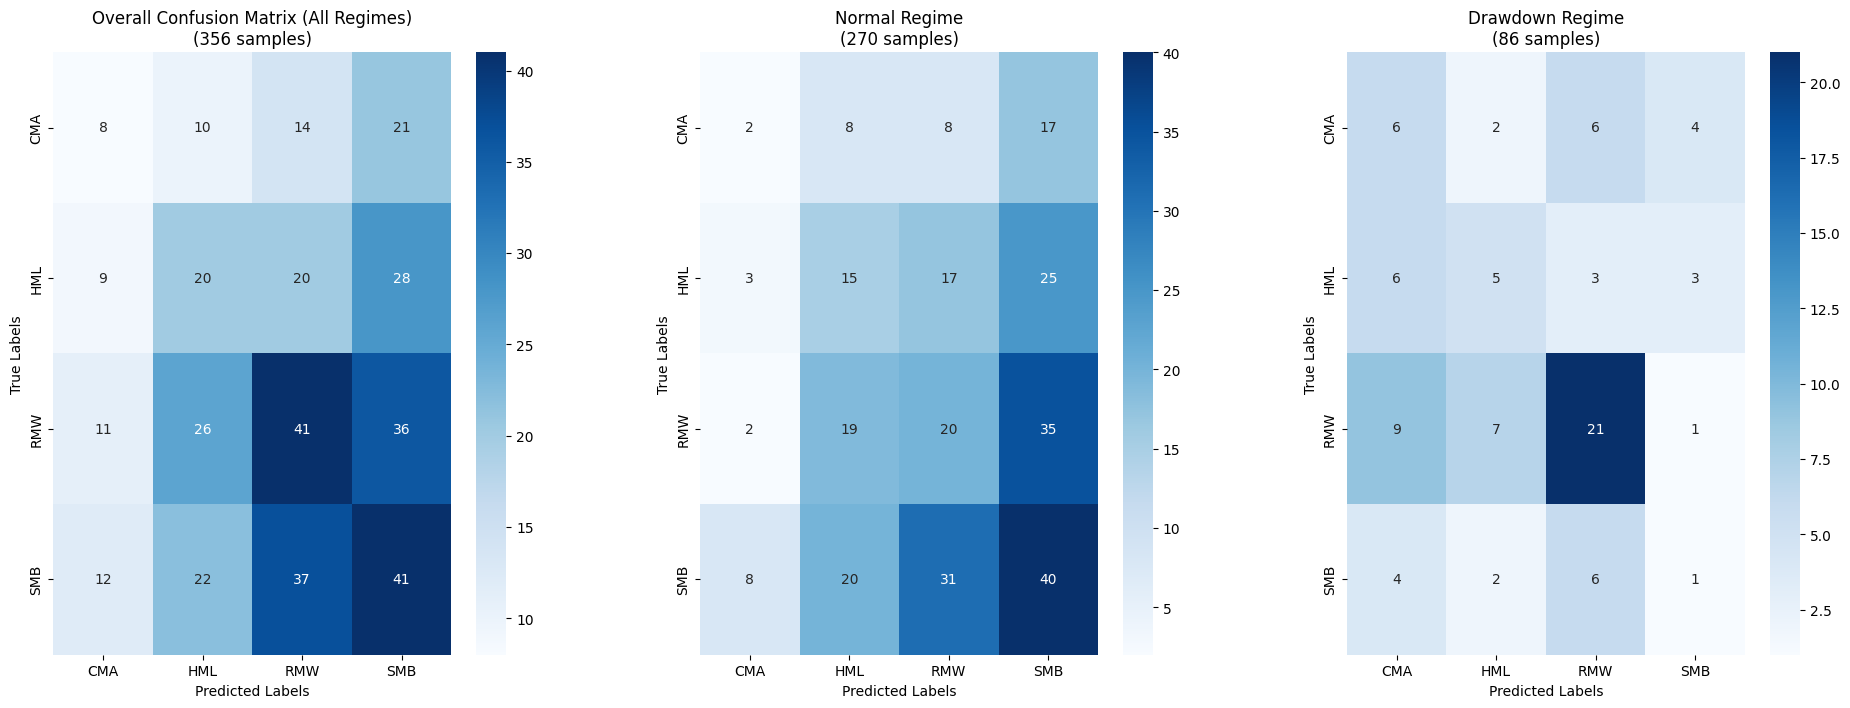

In [95]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get all unique regimes dynamically
all_regimes = results_df['Regime'].unique()

# Prepare labels from winning factors (sorted by their numeric IDs)
labels = [winning_factor_dict[winning_factor_mapping[i]]['short']
          for i in sorted(winning_factor_mapping.keys())]

# Convert to short names for actual/predicted values
all_true = results_df['Actual_Winner'].map(lambda x: factor_rename_mapping.get(x, x))
all_pred = results_df['Predicted_Winner'].map(lambda x: factor_rename_mapping.get(x, x))

# Create a figure with a grid layout for the confusion matrices
# Increase the figsize width by 30% (from 15 to 19.5)
fig, axes = plt.subplots(nrows=1, ncols=len(all_regimes) + 1, figsize=(19.5, 8))

# 1. Overall confusion matrix
cm_total = confusion_matrix(all_true, all_pred, labels=labels)
sns.heatmap(cm_total, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels,
            ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

# Calculate the number of samples for the overall matrix
total_samples = len(results_df)
axes[0].set_title(f"Overall Confusion Matrix (All Regimes)\n({total_samples} samples)")

# 2. Per-regime confusion matrices
for i, regime in enumerate(all_regimes):
    # Filter results for current regime
    regime_mask = results_df['Regime'] == regime
    regime_true = all_true[regime_mask]
    regime_pred = all_pred[regime_mask]

    if len(regime_true) == 0:
        print(f"\nNo samples for regime '{regime}'. Skipping confusion matrix.")
        continue

    # Plot the confusion matrix for the regime
    cm = confusion_matrix(regime_true, regime_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels,
                ax=axes[i+1])  # i+1 to place the regime-specific matrix
    axes[i+1].set_xlabel("Predicted Labels")
    axes[i+1].set_ylabel("True Labels")
    axes[i+1].set_title(f"{regime} Regime\n({len(regime_true)} samples)")

# Adjust layout to make space between the subplots
plt.tight_layout(pad=4.0)  # pad=4.0 adds space between subplots

# Adjust the spacing between subplots if needed
plt.subplots_adjust(wspace=0.3)  # Add space between subplots

# Show the plot
plt.show()



<ipython-input-96-d99f00845294>:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=4.0)


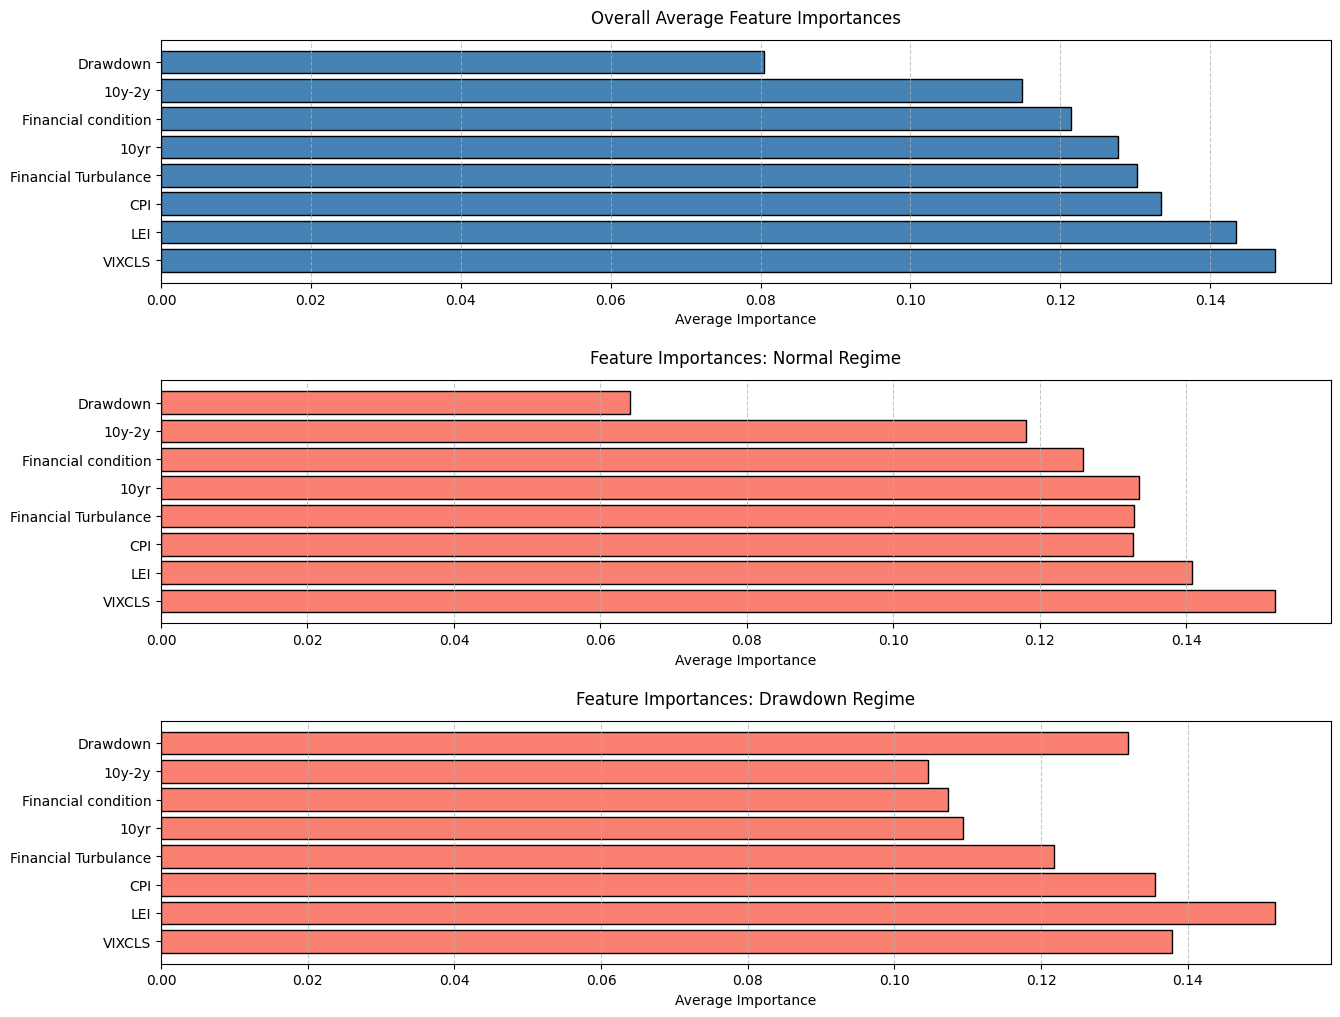

In [96]:
# --- Code cell 26 ---
# 2. Regime-Specific Feature Importances (Dynamic Version)
# ========================================================

import numpy as np
import matplotlib.pyplot as plt

# Get the unique regimes from results_df (already converted to string names)
existing_regimes = results_df['Regime'].unique()
n_regimes = len(existing_regimes)

# Dynamically get the number of features from the data
n_features = len(results_df['Feature_Importances'].iloc[0])  # Actual feature count

# Robust feature name handling:
try:
    # Validate FEATURES list length matches actual features
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features})")
        print("Using auto-generated feature names instead")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate descriptive feature names if there's a mismatch or error
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features")

# Compute overall average feature importances across all predictions
overall_avg_fi = np.vstack(results_df['Feature_Importances'].values).mean(axis=0)

# Calculate regime-specific average feature importances
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = results_df[results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# Sort features by overall importance in descending order
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # bounds check
sorted_features = [feature_names[i] for i in sorted_idx]

# 1) If we have more than one unique regime, make an overall + multiple regime subplots
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One for overall, one per regime
    # Figure height depends on number of plots and number of features
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]  # ensure iterable

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Plots ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)

# 2) Otherwise, if there's only zero or one regime, show only the overall chart
else:
    total_plots = 1
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )

    # --- Overall Feature Importances ---
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Provide extra space on the left for feature labels
plt.show()


Date Range: 1995-03-31 00:00:00 to 2024-10-31 00:00:00


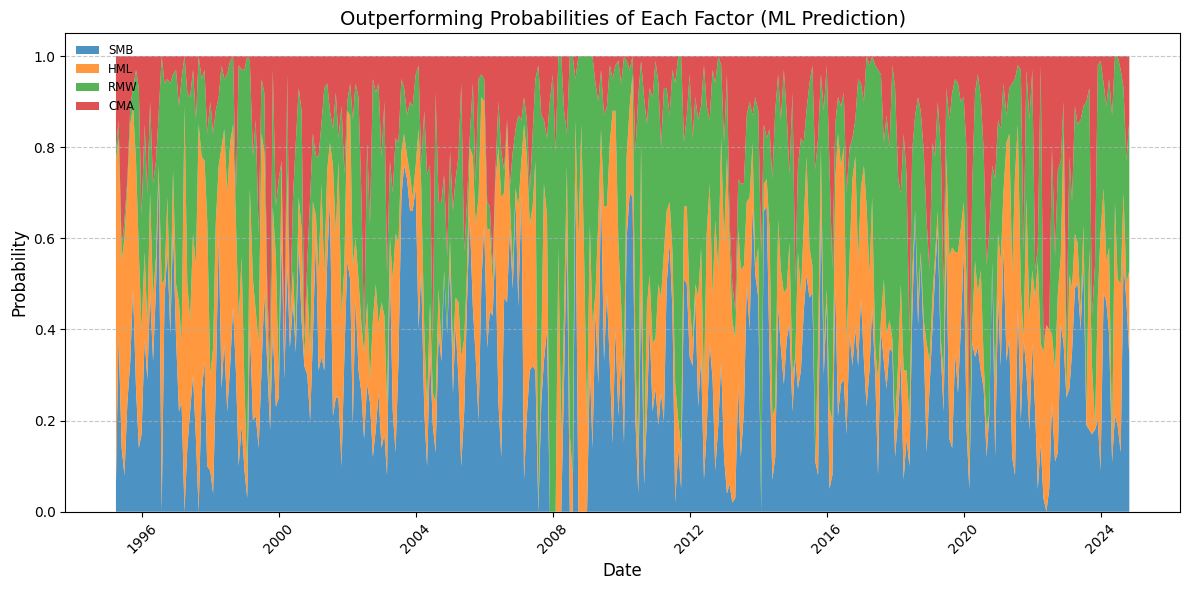

In [97]:
# Ensure proper date parsing with the correct format
probability_dates = pd.to_datetime(
    results_df["Predicted_month"],
    format='%Y-%m'  # Adjust this format to match your data (e.g., '%b-%Y' for "Jan-2005")
)

# Check for parsing errors or missing dates
if probability_dates.isna().any():
    print("Warning: Some dates could not be parsed. Handle missing dates.")
    # Drop NaT dates if appropriate
    results_df = results_df.loc[~probability_dates.isna()].copy()
    probability_dates = probability_dates.dropna()

# Proceed with the rest of your code
full_probs = np.vstack(results_df["Predicted_Probabilities"].values)
probability_df = pd.DataFrame(full_probs, columns=FACTORS)
probability_df["Date"] = probability_dates
probability_df = probability_df.sort_values("Date").reset_index(drop=True)

# Check date range
print("Date Range:", probability_df["Date"].min(), "to", probability_df["Date"].max())

# Plotting code remains the same...
plt.figure(figsize=(12, 6))
plt.stackplot(
    probability_df["Date"],
    [probability_df[col] for col in FACTORS],
    labels=FACTORS,
    alpha=0.8
)
plt.title("Outperforming Probabilities of Each Factor (ML Prediction)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.legend(loc='upper left', fontsize='small', frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Backtesting & statistics**

In [98]:
# Ensure the 'Predicted_month' column is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Get the earliest date from the 'Predicted_month' column
first_date = results_df['Predicted_month'].min()
last_date = results_df['Predicted_month'].max()

print("First date Predicted_month column in results_df:", first_date)
print("Last date in Predicted_month column results_df:", last_date)

First date Predicted_month column in results_df: 1995-03-31 00:00:00
Last date in Predicted_month column results_df: 2024-10-31 00:00:00


In [99]:
import pandas as pd

# ----- Part 1: Process results_df -----

# Ensure 'Predicted_month' is in datetime format
results_df['Predicted_month'] = pd.to_datetime(results_df['Predicted_month'])

# Define your dynamic date range (change these values as needed)
start_date = pd.to_datetime('1995-03-31')
end_date   = pd.to_datetime('2024-10-31')

# Filter results_df for the date range and select the desired columns
filtered_df = results_df.loc[
    (results_df['Predicted_month'] >= start_date) & (results_df['Predicted_month'] <= end_date),
    ['Predicted_month', 'Allocated_Return']
].sort_values('Predicted_month')

# Rename 'Allocated_Return' to 'ML Allocated Strategy Return'
filtered_df = filtered_df.rename(columns={'Allocated_Return': 'ML Allocated Strategy Return'})

# Calculate cumulative returns for the ML allocated strategy using compound returns,
# so that the wealth index starts at 1.
filtered_df['ML Cumulative Allocated Return'] = (1 + filtered_df['ML Allocated Strategy Return']).cumprod()


# ----- Part 2: Process the second DataFrame (df) without modifying it -----

# Create a filtered copy of df for the same date range using the 'Date' column.
df_filtered = df.loc[
    (pd.to_datetime(df['Date']) >= start_date) & (pd.to_datetime(df['Date']) <= end_date)
].copy()

# Ensure the 'Date' column is datetime for correct sorting and merging
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Sort by 'Date'
df_filtered = df_filtered.sort_values('Date')

# Calculate cumulative returns for the benchmark column ('USA Standard (Large+Mid Cap)')
df_filtered['USA_Cumulative_Return'] = (1 + df_filtered['USA Standard (Large+Mid Cap)']).cumprod()

# Calculate the Equal Factor Weight Strategy returns by taking an equal-weight average of the 5 factors
df_filtered['Equal Factor Weight Strategy'] = (
    df_filtered['SMB'] +
    df_filtered['HML'] +
    df_filtered['CMA'] +
    df_filtered['RMW']
) / 4

# Calculate cumulative returns for the Equal Factor Weight Strategy using compound returns,
# so that the wealth index starts at 1.
df_filtered['Equal Factor Weight Cumulative Return'] = (1 + df_filtered['Equal Factor Weight Strategy']).cumprod()

# --- New: Calculate the Momentum Strategy returns and cumulative returns ---
# Create a monthly returns column for the Momentum Strategy.
df_filtered['SMB Strategy Return'] = df_filtered['SMB']

# Calculate cumulative returns for the Momentum Strategy using compound returns,
# so that the wealth index starts at 1.
df_filtered['SMB Strategy Cumulative Return'] = (1 + df_filtered['SMB Strategy Return']).cumprod()


# ----- Part 3: Merge the two DataFrames -----

# Merge the filtered DataFrames on their date columns ('Predicted_month' in filtered_df and 'Date' in df_filtered)
merged_df = pd.merge(
    filtered_df,
    df_filtered[['Date', 'USA Standard (Large+Mid Cap)', 'USA_Cumulative_Return',
                 'Equal Factor Weight Strategy', 'Equal Factor Weight Cumulative Return',
                 'SMB Strategy Return', 'SMB Strategy Cumulative Return']],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)

# Drop the extra 'Date' column from the merged result
merged_df.drop(columns=['Date'], inplace=True)

# Rename 'USA_Cumulative_Return' to 'Benchmark Cumulative Returns'
merged_df = merged_df.rename(columns={'USA_Cumulative_Return': 'Benchmark Cumulative Returns'})

# Display the final merged DataFrame
print(merged_df)

    Predicted_month  ML Allocated Strategy Return  \
0        1995-03-31                     -0.015143   
1        1995-04-28                      0.007919   
2        1995-05-31                      0.006608   
3        1995-06-30                     -0.019676   
4        1995-07-31                     -0.006993   
..              ...                           ...   
351      2024-06-28                     -0.016396   
352      2024-07-31                      0.033165   
353      2024-08-30                     -0.019213   
354      2024-09-30                     -0.006218   
355      2024-10-31                     -0.004413   

     ML Cumulative Allocated Return  USA Standard (Large+Mid Cap)  \
0                          0.984857                      0.024727   
1                          0.992656                      0.029374   
2                          0.999216                      0.037064   
3                          0.979555                      0.022689   
4                 

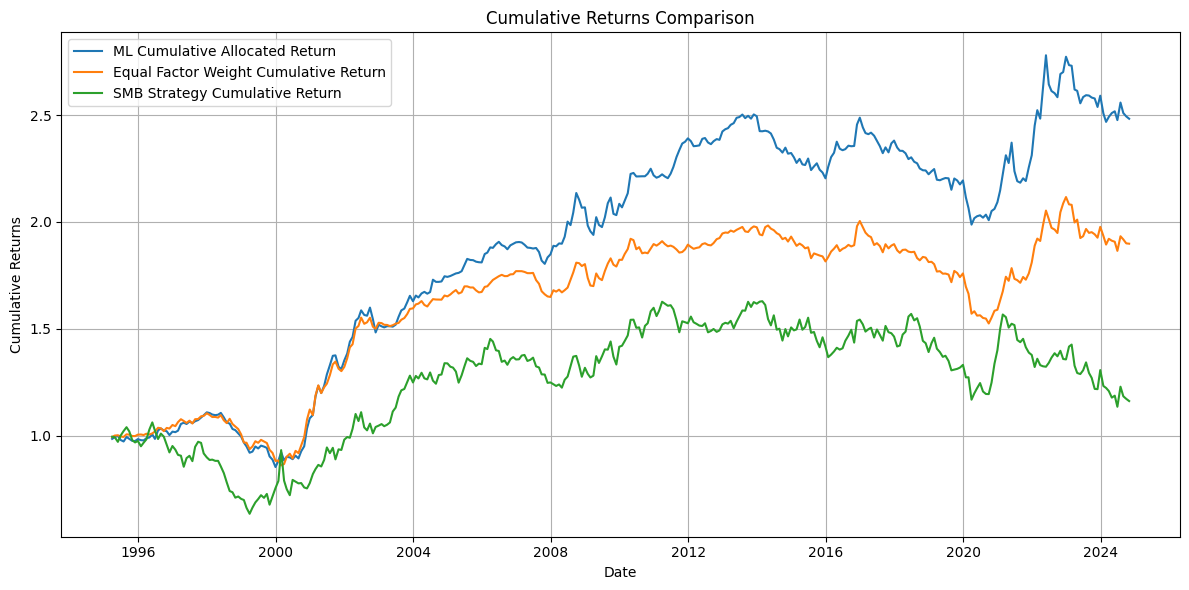

In [100]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by date
merged_df = merged_df.sort_values('Predicted_month')

plt.figure(figsize=(12, 6))

# Plot the ML Cumulative Allocated Return without markers
plt.plot(
    merged_df['Predicted_month'],
    merged_df['ML Cumulative Allocated Return'],
    label='ML Cumulative Allocated Return'
)


# Plot the Equal Factor Weight Cumulative Return without markers
plt.plot(
    merged_df['Predicted_month'],
    merged_df['Equal Factor Weight Cumulative Return'],
    label='Equal Factor Weight Cumulative Return'
)

# Plot the Momentum Strategy Cumulative Return without markers
plt.plot(
    merged_df['Predicted_month'],
    merged_df['SMB Strategy Cumulative Return'],
    label='SMB Strategy Cumulative Return'
)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
import numpy as np

# --- PERFORMANCE METRICS ---

# For the ML Allocated Strategy:
ml_returns = merged_df['ML Allocated Strategy Return']
ml_mean_monthly = ml_returns.mean()
ml_std_monthly  = ml_returns.std()
ml_annualized_return = ml_mean_monthly * 12
ml_annualized_vol    = ml_std_monthly * np.sqrt(12)
ml_sharpe            = ml_annualized_return / ml_annualized_vol

# For the Benchmark:
benchmark_returns = merged_df['USA Standard (Large+Mid Cap)']
benchmark_mean_monthly = benchmark_returns.mean()
benchmark_std_monthly  = benchmark_returns.std()
benchmark_annualized_return = benchmark_mean_monthly * 12
benchmark_annualized_vol    = benchmark_std_monthly * np.sqrt(12)
benchmark_sharpe            = benchmark_annualized_return / benchmark_annualized_vol

# For the Equal Factor Weight Strategy:
equal_returns = merged_df['Equal Factor Weight Strategy']
equal_mean_monthly = equal_returns.mean()
equal_std_monthly  = equal_returns.std()
equal_annualized_return = equal_mean_monthly * 12
equal_annualized_vol    = equal_std_monthly * np.sqrt(12)
equal_sharpe            = equal_annualized_return / equal_annualized_vol

# For the Momentum Strategy:
momentum_returns = merged_df['SMB Strategy Return']
momentum_mean_monthly = momentum_returns.mean()
momentum_std_monthly  = momentum_returns.std()
momentum_annualized_return = momentum_mean_monthly * 12
momentum_annualized_vol    = momentum_std_monthly * np.sqrt(12)
momentum_sharpe            = momentum_annualized_return / momentum_annualized_vol

# --- PRINT PERFORMANCE METRICS ---
print("\nPERFORMANCE METRICS:\n")

print("ML Allocated Strategy:")
print(f"  Annualized Return:      {ml_annualized_return:.2%}")
print(f"  Annualized Volatility:  {ml_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {ml_sharpe:.2f}\n")

print("Equal Factor Weight Strategy:")
print(f"  Annualized Return:      {equal_annualized_return:.2%}")
print(f"  Annualized Volatility:  {equal_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {equal_sharpe:.2f}\n")

print("Momentum Strategy:")
print(f"  Annualized Return:      {momentum_annualized_return:.2%}")
print(f"  Annualized Volatility:  {momentum_annualized_vol:.2%}")
print(f"  Sharpe Ratio:           {momentum_sharpe:.2f}\n")


# --- MAXIMUM DRAWDOWN CALCULATIONS ---
# Compute wealth indexes starting at 1 for each strategy.
wealth_ml = (1 + merged_df['ML Allocated Strategy Return']).cumprod()
wealth_benchmark = (1 + merged_df['USA Standard (Large+Mid Cap)']).cumprod()
wealth_equal = (1 + merged_df['Equal Factor Weight Strategy']).cumprod()
wealth_momentum = (1 + merged_df['SMB Strategy Return']).cumprod()

# Compute drawdown series for each strategy:
drawdown_ml = wealth_ml / wealth_ml.cummax() - 1
drawdown_benchmark = wealth_benchmark / wealth_benchmark.cummax() - 1
drawdown_equal = wealth_equal / wealth_equal.cummax() - 1
drawdown_momentum = wealth_momentum / wealth_momentum.cummax() - 1

# Maximum drawdown is the minimum value in the drawdown series
max_dd_ml = drawdown_ml.min()
max_dd_benchmark = drawdown_benchmark.min()
max_dd_equal = drawdown_equal.min()
max_dd_momentum = drawdown_momentum.min()

print("MAXIMUM DRAWDOWNS:\n")
print("ML Allocated Strategy Max Drawdown:       ", f"{max_dd_ml:.2%}")
print("Equal Factor Weight Strategy Max Drawdown:  ", f"{max_dd_equal:.2%}")
print("SMB Strategy Max Drawdown:             ", f"{max_dd_momentum:.2%}")


PERFORMANCE METRICS:

ML Allocated Strategy:
  Annualized Return:      3.29%
  Annualized Volatility:  6.65%
  Sharpe Ratio:           0.49

Equal Factor Weight Strategy:
  Annualized Return:      2.33%
  Annualized Volatility:  5.90%
  Sharpe Ratio:           0.40

Momentum Strategy:
  Annualized Return:      1.11%
  Annualized Volatility:  11.02%
  Sharpe Ratio:           0.10

MAXIMUM DRAWDOWNS:

ML Allocated Strategy Max Drawdown:        -23.09%
Equal Factor Weight Strategy Max Drawdown:   -23.93%
SMB Strategy Max Drawdown:              -40.28%


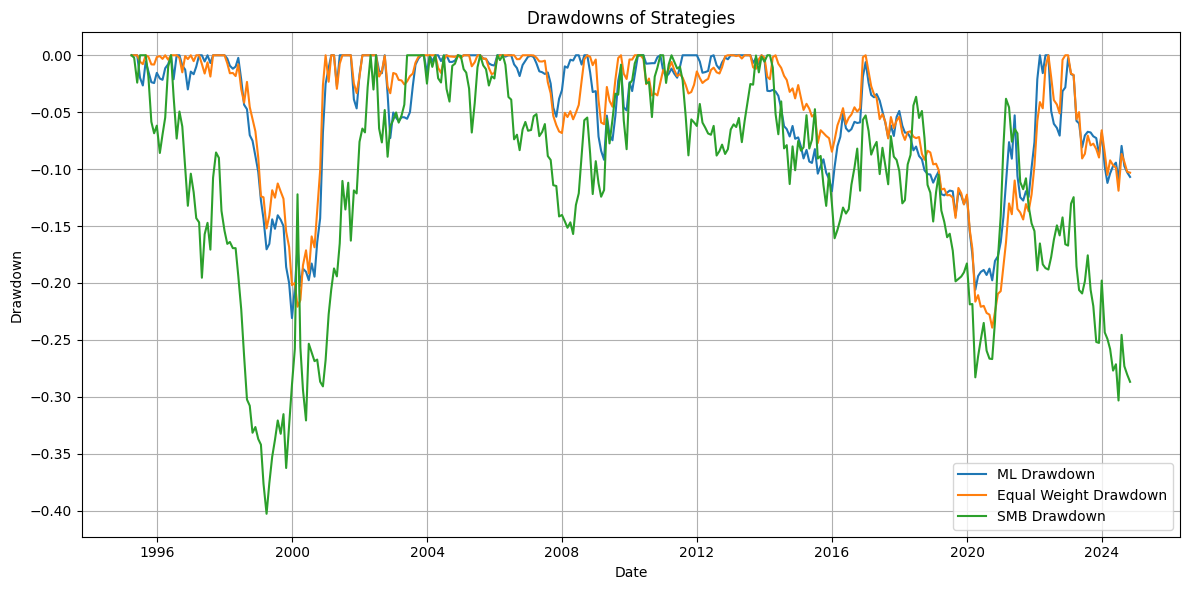

In [102]:
import matplotlib.pyplot as plt

# --- Compute Drawdowns for Each Strategy ---

# ML Allocated Strategy Drawdown
merged_df['ML Drawdown'] = merged_df['ML Cumulative Allocated Return'] / merged_df['ML Cumulative Allocated Return'].cummax() - 1

# Benchmark Drawdown
merged_df['Benchmark Drawdown'] = merged_df['Benchmark Cumulative Returns'] / merged_df['Benchmark Cumulative Returns'].cummax() - 1

# Equal Factor Weight Strategy Drawdown
merged_df['Equal Weight Drawdown'] = merged_df['Equal Factor Weight Cumulative Return'] / merged_df['Equal Factor Weight Cumulative Return'].cummax() - 1

# Momentum Strategy Drawdown
merged_df['SMB Drawdown'] = merged_df['SMB Strategy Cumulative Return'] / merged_df['SMB Strategy Cumulative Return'].cummax() - 1

# --- Plot the Drawdowns ---
plt.figure(figsize=(12, 6))

plt.plot(merged_df['Predicted_month'], merged_df['ML Drawdown'], label='ML Drawdown')
#plt.plot(merged_df['Predicted_month'], merged_df['Benchmark Drawdown'], label='Benchmark Drawdown')
plt.plot(merged_df['Predicted_month'], merged_df['Equal Weight Drawdown'], label='Equal Weight Drawdown')
plt.plot(merged_df['Predicted_month'], merged_df['SMB Drawdown'], label='SMB Drawdown')

plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Drawdowns of Strategies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
import statsmodels.api as sm

# --- Step 1: Merge the additional factor columns into merged_df ---
# Assume that in df, the factor columns and a date column are available:
# Columns: 'Date', 'SMB', 'HML', 'RMW', 'CMA'
# We merge on the date columns, where merged_df has 'Predicted_month' (as datetime)
merged_df = merged_df.merge(
    df[['Date', 'SMB', 'HML', 'RMW', 'CMA']],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)
# Drop the duplicate 'Date' column from the merge
merged_df.drop(columns=['Date'], inplace=True)

# --- Step 2: Multi-Factor Regression for the ML Allocated Strategy ---

# Define the independent variables (market returns and FF factors)
X_ml = merged_df[['USA Standard (Large+Mid Cap)', 'SMB', 'HML', 'RMW', 'CMA']]
X_ml = sm.add_constant(X_ml)  # add the intercept

# Dependent variable: ML Allocated Strategy Return (excess returns)
y_ml = merged_df['ML Allocated Strategy Return']

# Run the multi-factor OLS regression for the ML strategy
model_ml = sm.OLS(y_ml, X_ml).fit()

print("Regression Results: ML Allocated Strategy vs FF Factors")
print(model_ml.summary())

# --- Step 3: Multi-Factor Regression for the Equal Factor Weight Strategy ---

# Define the independent variables (same as above)
X_eq = merged_df[['USA Standard (Large+Mid Cap)', 'SMB', 'HML', 'RMW', 'CMA']]
X_eq = sm.add_constant(X_eq)

# Dependent variable: Equal Factor Weight Strategy Return (excess returns)
y_eq = merged_df['Equal Factor Weight Strategy']

# Run the multi-factor OLS regression for the Equal Factor Weight Strategy
model_eq = sm.OLS(y_eq, X_eq).fit()

print("\nRegression Results: Equal Factor Weight Strategy vs FF Factors")
print(model_eq.summary())

# --- Step 4: Annualize the Alpha and Report t-Statistic and p-Value ---

# For the ML strategy:
alpha_ml = model_ml.params['const']            # monthly alpha
annualized_alpha_ml = alpha_ml * 12              # simple annualization (for small values)
t_alpha_ml = model_ml.tvalues['const']
p_alpha_ml = model_ml.pvalues['const']

# For the Equal Factor Weight Strategy:
alpha_eq = model_eq.params['const']
annualized_alpha_eq = alpha_eq * 12
t_alpha_eq = model_eq.tvalues['const']
p_alpha_eq = model_eq.pvalues['const']

print("\nAnnualized Alpha Metrics:")
print("ML Allocated Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_ml:.2%}")
print(f"  T-statistic:      {t_alpha_ml:.2f}")
print(f"  P-value:          {p_alpha_ml:.4f}")

print("\nEqual Factor Weight Strategy:")
print(f"  Annualized Alpha: {annualized_alpha_eq:.2%}")
print(f"  T-statistic:      {t_alpha_eq:.2f}")
print(f"  P-value:          {p_alpha_eq:.4f}")

Regression Results: ML Allocated Strategy vs FF Factors
                                 OLS Regression Results                                 
Dep. Variable:     ML Allocated Strategy Return   R-squared:                       0.734
Model:                                      OLS   Adj. R-squared:                  0.730
Method:                           Least Squares   F-statistic:                     192.7
Date:                          Fri, 14 Feb 2025   Prob (F-statistic):           3.38e-98
Time:                                  14:02:34   Log-Likelihood:                 1138.0
No. Observations:                           356   AIC:                            -2264.
Df Residuals:                               350   BIC:                            -2241.
Df Model:                                     5                                         
Covariance Type:                      nonrobust                                         
                                   coef    std err    

In [104]:
# Create a Year column from the 'Predicted_month'
merged_df['Year'] = merged_df['Predicted_month'].dt.year

def annual_sharpe(group, col):
    """
    Calculate the annual Sharpe ratio for a given return column within a group (year).
    Annual Return is computed as the product of (1 + monthly return) minus 1.
    Annual Volatility is computed as the standard deviation of monthly returns * sqrt(12).
    The Sharpe ratio is then annual return divided by annual volatility.
    """
    # Compound monthly returns to get the annual return:
    annual_return = (1 + group[col]).prod() - 1
    # Annualize the monthly volatility:
    annual_vol = group[col].std() * np.sqrt(12)
    # Compute Sharpe ratio (assume risk-free rate = 0)
    sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan
    return sharpe

# Calculate annual Sharpe ratios for each strategy by grouping on 'Year'
sharpe_ml = merged_df.groupby('Year').apply(lambda grp: annual_sharpe(grp, 'ML Allocated Strategy Return'))
sharpe_bench = merged_df.groupby('Year').apply(lambda grp: annual_sharpe(grp, 'USA Standard (Large+Mid Cap)'))
sharpe_equal = merged_df.groupby('Year').apply(lambda grp: annual_sharpe(grp, 'Equal Factor Weight Strategy'))

# Combine the Sharpe ratios into one DataFrame
annual_sharpe_table = pd.DataFrame({
    'ML Sharpe Ratio': sharpe_ml,
    'Benchmark Sharpe Ratio': sharpe_bench,
    'Equal Weight Sharpe Ratio': sharpe_equal
})

# Optionally format the table for clearer display (2 decimal places)
annual_sharpe_table = annual_sharpe_table.applymap(lambda x: f"{x:.2f}" if pd.notnull(x) else x)

print("Yearly Sharpe Ratios:")
print(annual_sharpe_table)

Yearly Sharpe Ratios:
     ML Sharpe Ratio Benchmark Sharpe Ratio Equal Weight Sharpe Ratio
Year                                                                 
1995           -0.37                   4.69                      0.21
1996            0.61                   1.98                      1.41
1997            2.59                   1.95                      1.38
1998           -2.96                   1.36                     -1.97
1999           -1.97                   1.53                     -1.64
2000            2.26                  -0.79                      2.42
2001            2.20                  -0.67                      1.56
2002            1.28                  -1.14                      1.99
2003            1.74                   2.34                      2.05
2004            1.71                   1.20                      1.36
2005            1.71                   0.48                      0.50
2006            1.75                   2.22                      3.5

<ipython-input-104-9e4d9a4a76ba>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sharpe_ml = merged_df.groupby('Year').apply(lambda grp: annual_sharpe(grp, 'ML Allocated Strategy Return'))
<ipython-input-104-9e4d9a4a76ba>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sharpe_bench = merged_df.groupby('Year').apply(lambda grp: annual_sharpe(grp, 'USA Standard (Large+Mid Cap)'))
<ipython-input-104-9e4d9a

# Corr Heat map & regiimi sharpet


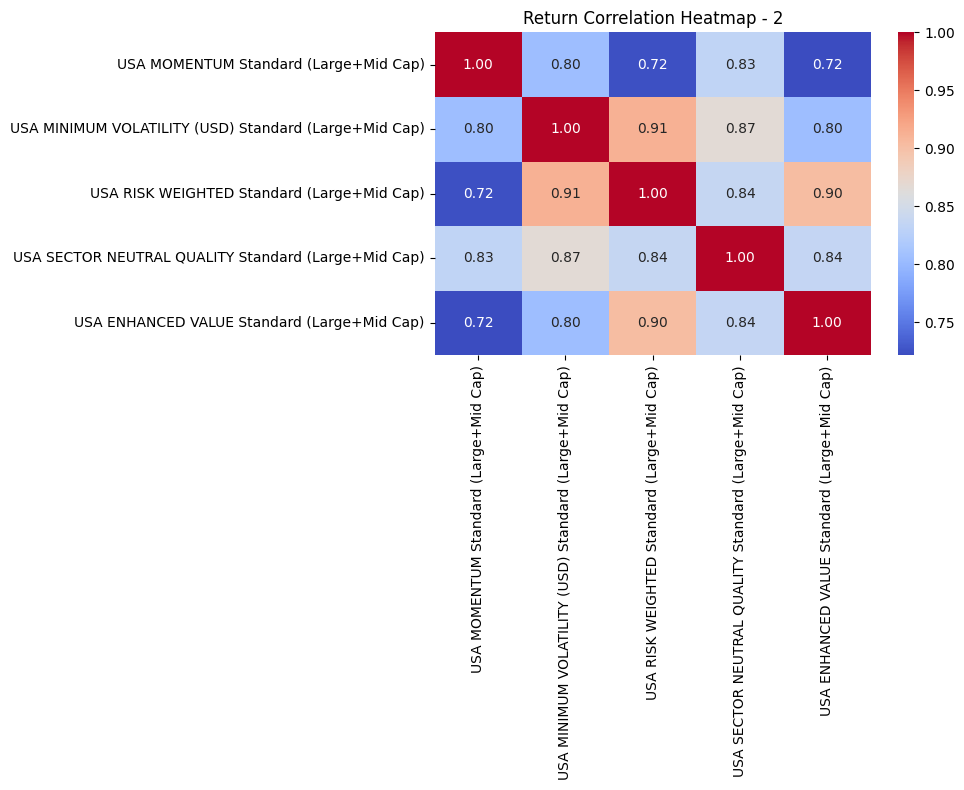

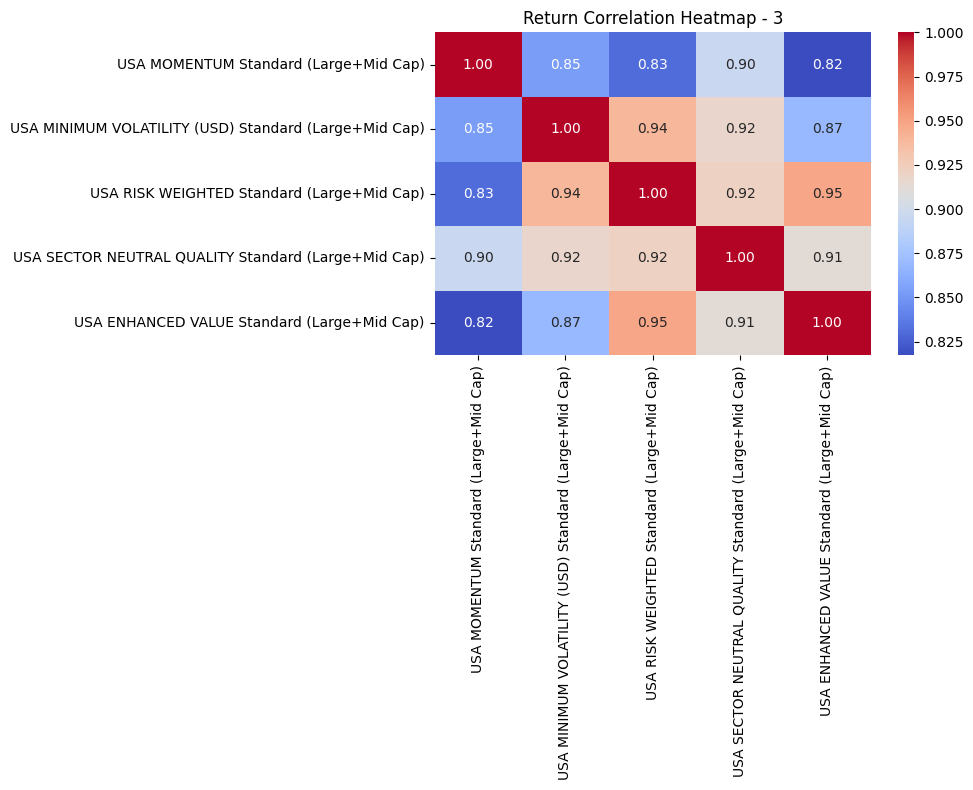

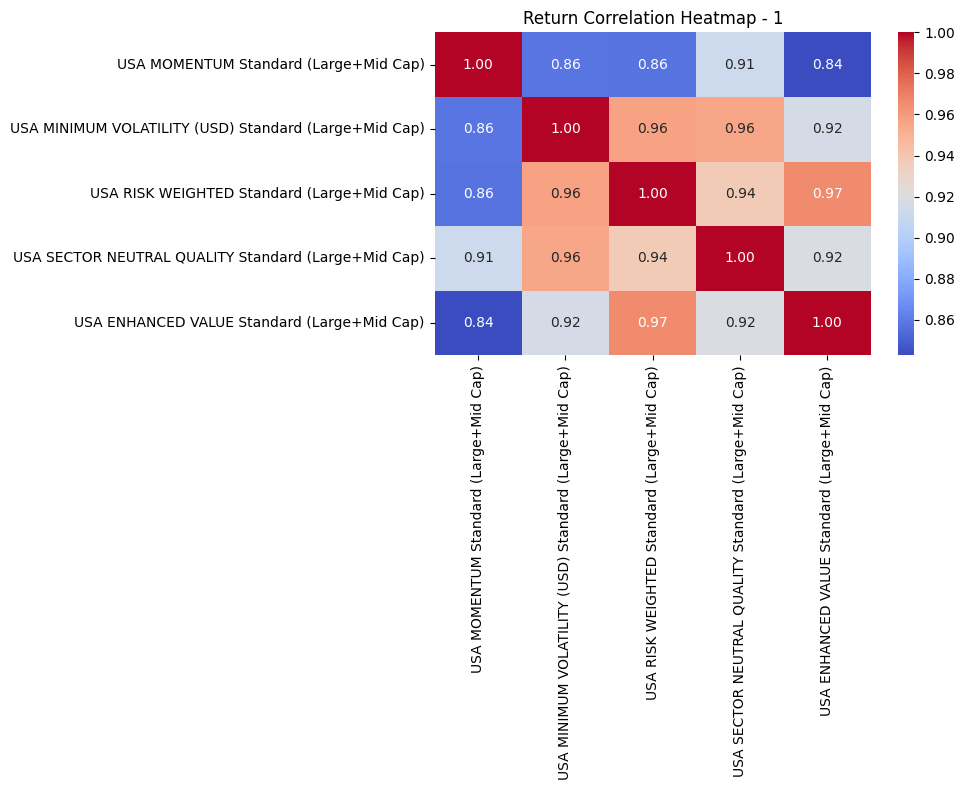

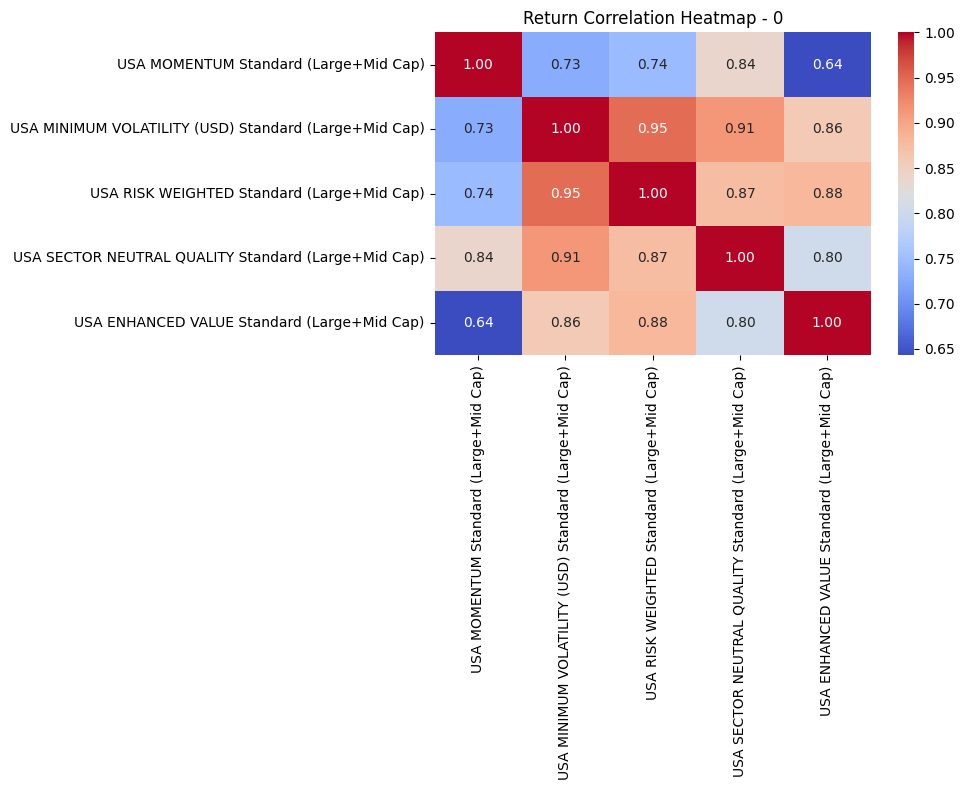

In [ ]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



<Figure size 1400x800 with 0 Axes>

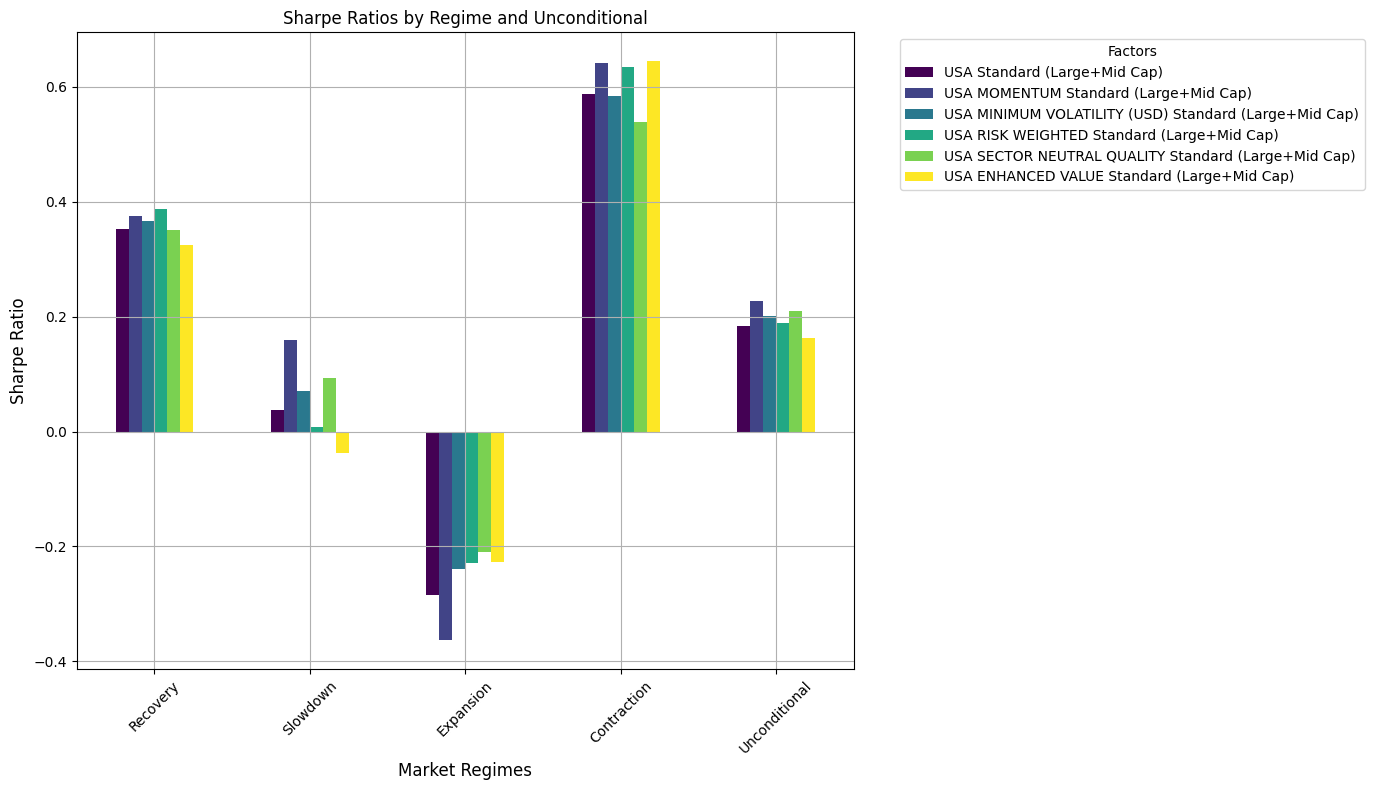

In [ ]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = df.columns[1:7]  # Adjust the column indices if needed
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

# Calculate Sharpe ratios by regime using a dictionary comprehension and use the short names as keys.
sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# --- Code cell: Export results to CSV ---

import pandas as pd

# 1) Merge the monthly ML strategy returns (from merged_df) into results_df
#    so that we have both "ML Allocated Strategy Return" and "Allocated_Return"
df_with_ml = pd.merge(
    results_df,
    merged_df[['Predicted_month', 'ML Allocated Strategy Return']],
    on='Predicted_month',
    how='left'
)

# 2) Merge the factor returns and benchmark from the original df
#    so that we have columns for each factor's monthly returns.
factor_columns = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]
benchmark_col = 'USA Standard (Large+Mid Cap)'

df_with_factors = pd.merge(
    df_with_ml,
    df[['Date', benchmark_col] + factor_columns],
    left_on='Predicted_month',
    right_on='Date',
    how='left'
)

# 3) Identify the probability columns (those ending with '_prob', e.g. "Momentum_prob")
probability_columns = [col for col in df_with_factors.columns if col.endswith('_prob')]

# 4) Select and rename columns for clarity in the final CSV
#    Required columns (in order):
#       date
#       benchmark
#       return (ML strategy monthly return)
#       factor returns (one column per factor)
#       winning probabilities (one column per factor-prob)
#       allocated return (from the RF model)
columns_for_csv = [
    'Predicted_month',            # date
    benchmark_col,                # benchmark
    'ML Allocated Strategy Return',    # ML strategy's monthly return
] + factor_columns + probability_columns + [
    'Allocated_Return'            # allocated return from the classifier's probabilities
]

df_export = df_with_factors[columns_for_csv].copy()

# Rename the columns to match your exact specification
df_export = df_export.rename(columns={
    'Predicted_month': 'Date',
    benchmark_col:     'Benchmark_Return',
    'ML Allocated Strategy Return': 'ML_Strategy_Return',
    'Allocated_Return': 'Allocated_Return'
})

# 5) Export the DataFrame to CSV with ';' as the separator
output_filename = 'model_verification.csv'
df_export.to_csv(output_filename, sep=';', index=False)

print(f"CSV file '{output_filename}' has been created with the following columns:")
print(df_export.columns.tolist())
print("\nPreview:")
display(df_export.head(10))


CSV file 'model_verification.csv' has been created with the following columns:
['Date', 'Benchmark_Return', 'ML_Strategy_Return', 'USA MOMENTUM Standard (Large+Mid Cap)', 'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)', 'USA RISK WEIGHTED Standard (Large+Mid Cap)', 'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)', 'USA ENHANCED VALUE Standard (Large+Mid Cap)', 'Momentum_prob', 'MinVol_prob', 'RiskWeighted_prob', 'SectorNeutral_prob', 'EnhancedValue_prob', 'Allocated_Return']

Preview:


,Date,Benchmark_Return,ML_Strategy_Return,USA MOMENTUM Standard (Large+Mid Cap),USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap),USA RISK WEIGHTED Standard (Large+Mid Cap),USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),USA ENHANCED VALUE Standard (Large+Mid Cap),Momentum_prob,MinVol_prob,RiskWeighted_prob,SectorNeutral_prob,EnhancedValue_prob,Allocated_Return
0,2010-03-31,0.058294,0.057830,0.072695,0.034406,0.052558,0.053528,0.058443,0.19,0.03,0.40,0.05,0.33,0.057830
1,2010-04-30,0.014979,0.008097,0.005244,0.006829,0.020492,0.014479,0.008436,0.43,0.07,0.07,0.05,0.38,0.008097
2,2010-05-31,-0.082683,-0.079320,-0.069345,-0.060741,-0.067227,-0.083000,-0.091558,0.27,0.08,0.12,0.10,0.43,-0.079320
3,2010-06-30,-0.054712,-0.044764,-0.055213,-0.018473,-0.041224,-0.036405,-0.073816,0.16,0.38,0.04,0.10,0.32,-0.044764
4,2010-07-30,0.068638,0.065905,0.076591,0.045698,0.059118,0.060141,0.064052,0.30,0.03,0.18,0.12,0.37,0.065905
5,2010-08-31,-0.046664,-0.030248,-0.045631,-0.015592,-0.031265,-0.035775,-0.054816,0.22,0.46,0.07,0.15,0.10,-0.030248
6,2010-09-30,0.089214,0.091834,0.102945,0.068477,0.083301,0.087912,0.099139,0.25,0.15,0.16,0.10,0.34,0.091834
7,2010-10-29,0.038197,0.040616,0.048866,0.030358,0.033851,0.039221,0.038219,0.33,0.06,0.15,0.01,0.45,0.040616
8,2010-11-30,-0.001214,0.001399,0.016691,-0.010552,0.000256,-0.003223,-0.012007,0.40,0.06,0.15,0.00,0.39,0.001399
9,2010-12-31,0.065185,0.052824,0.040236,0.047259,0.053646,0.047709,0.079198,0.49,0.06,0.21,0.00,0.24,0.052824
